In [1]:
import numpy as np
import os
from tqdm import tqdm_notebook
import h5py
import time
from sklearn.model_selection import train_test_split
import gc
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import get_file
import tensorflow.keras as ks
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import he_normal

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard

import matplotlib.pyplot as plt

%matplotlib inline

# TODO

* swich custom activation

In [2]:
seed = 0
num_epochs = 500
batch_size = 64
weight_decay  = 0.005
dropout = 0.35
iterations = 2700

In [3]:
def scheduler(epoch):
    if epoch < 25:
        return 0.0001
    if epoch < 45:
        return 0.00001
    return 0.000001

# Callback for tensorboard
tb_cb = TensorBoard(log_dir='./age_cnn_data_gen', histogram_freq=10)

checkpoint_path = "training_3/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                           save_weights_only=True,
                                           verbose=1,
                                           epochs_pr_checkpoint=1)

# callback for learning rate 
change_lr_cb = LearningRateScheduler(scheduler)

cbks = [cp_cb, tb_cb, change_lr_cb]

In [4]:
def categorize(ages):
    ages_copy=np.array(ages,copy=True)

    for i in range(len(ages)):
        if 0 < ages_copy[i] <= 18:
            ages_copy[i] = 0
        elif 18 < ages_copy[i] <= 29:
            ages_copy[i] = 1
        elif 29 < ages_copy[i] <= 39:
            ages_copy[i] = 2
        elif 39 < ages_copy[i] <= 49:
            ages_copy[i] = 3
        elif 49 < ages_copy[i] <= 59:
            ages_copy[i] = 4
        elif ages_copy[i] >= 60:
            ages_copy[i] = 5

    categorical = to_categorical(ages_copy)
    return categorical

In [5]:
def load_data(seed):
    with h5py.File('imdb_preprocesed.hdf5', 'r') as f:
        i_ages = np.array(f.get('ages'))
        i_images = np.array(f.get('images'))

    print("Part 1 done!")

    with h5py.File('wiki_preprocesed.hdf5', 'r') as f:
        w_ages = np.array(f.get('ages'))
        w_images = np.array(f.get('images'))

    print("Load done!\nCreating dataset")
    gc.collect()
    
    i_x_train, i_x_test, i_y_train, i_y_test = train_test_split(i_images, i_ages, test_size = 0.1, random_state=seed)
    w_x_train, w_x_test, w_y_train, w_y_test = train_test_split(w_images, w_ages, test_size = 0.1, random_state=seed)
    
    x_train = np.concatenate([i_x_train, w_x_train])
    y_train = np.concatenate([i_y_train, w_y_train])
    
    x_test = np.concatenate([i_x_test, w_x_test])
    y_test = np.concatenate([i_y_test, w_y_test])
    
    y_train = categorize(y_train)
    y_test = categorize(y_test)
    
    print("All done!")
    gc.collect()
    return x_train, x_test, y_train, y_test

In [6]:
# load and split the data
x_train, x_test, y_train, y_test = load_data(seed)

# split the training in train and validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state=seed)

Part 1 done!
Load done!
Creating dataset
All done!


array([ 8502., 49194., 53382., 33328., 16169., 12363.], dtype=float32)

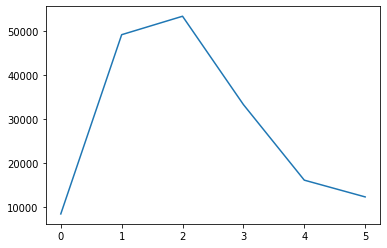

In [7]:
plt.plot(np.sum(y_train, axis=0))
np.sum(y_train, axis=0)

array([1070., 6099., 6585., 4045., 1970., 1583.], dtype=float32)

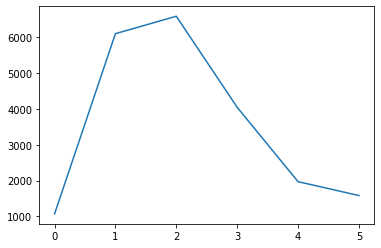

In [8]:
plt.plot(np.sum(y_test, axis=0))
np.sum(y_test, axis=0)

array([ 897., 5473., 6066., 3622., 1795., 1363.], dtype=float32)

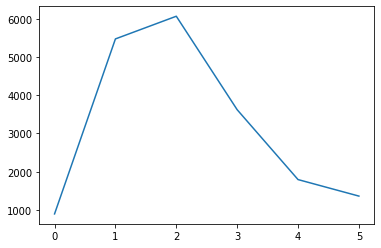

In [9]:
plt.plot(np.sum(y_val, axis=0))
np.sum(y_val, axis=0)

In [10]:
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

(172938, 64, 64, 3)
(21352, 64, 64, 3)
(19216, 64, 64, 3)


In [11]:
datagen = ImageDataGenerator(horizontal_flip=True,
                            width_shift_range=0.125,
                            height_shift_range=0.125,
                            fill_mode='constant', cval=0,
                            rotation_range = 20)
datagen.fit(x_train)

In [6]:
def createConvModel(inputDimensions, outputDimensions):
    model = Sequential()
    
    # Convblock 1
    model.add(Conv2D(64, kernel_size=3, padding='same',kernel_regularizer=l2(weight_decay), input_shape=inputDimensions))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2D(64, kernel_size=3, padding='same',kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
        
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
    # Convblock 2
    model.add(Conv2D(128, kernel_size=3, padding='same',kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2D(128, kernel_size=3, padding='same',kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
    # Convblock 3
    model.add(Conv2D(256, kernel_size=3, padding='same',kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2D(256, kernel_size=3, padding='same',kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(256, kernel_size=3, padding='same',kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(256, kernel_size=3, padding='same',kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
    # Conv block 4
    model.add(Conv2D(512, kernel_size=3, padding='same',kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(512, kernel_size=3, padding='same',kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
    # Dense finale
    model.add(Flatten())
    
    model.add(Dense(2048, kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    
    model.add(Dense(2048, kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    
    model.add(Dense(outputDimensions, activation="softmax"))
    
    ks.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [7]:
# VGG
def VGG_model(inputDimensions, outputDimensions):
    # path to pretrained weights for vgg
    WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels.h5'
    # keras implementation of downloading the tretrained weights for our vgg model
    filepath = get_file('vgg19_weights_tf_dim_ordering_tf_kernels.h5', WEIGHTS_PATH, cache_subdir='models')
    
    # keras sequential model
    model = ks.Sequential()

    # Block 1
    model.add(Conv2D(64, (3, 3), padding='same',
                     kernel_regularizer=l2(weight_decay),
                     kernel_initializer=he_normal(),
                     name='block1_conv1',
                     input_shape=inputDimensions))

    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(weight_decay), kernel_initializer=he_normal(), name='block1_conv2'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))

    # Block 2
    model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(weight_decay), kernel_initializer=he_normal(), name='block2_conv1'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(weight_decay), kernel_initializer=he_normal(), name='block2_conv2'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))

    # Block 3
    model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(weight_decay), kernel_initializer=he_normal(), name='block3_conv1'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(weight_decay), kernel_initializer=he_normal(), name='block3_conv2'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(weight_decay), kernel_initializer=he_normal(), name='block3_conv3'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(weight_decay), kernel_initializer=he_normal(), name='block3_conv4'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))

    # Block 4
    model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(weight_decay), kernel_initializer=he_normal(), name='block4_conv1'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(weight_decay), kernel_initializer=he_normal(), name='block4_conv2'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(weight_decay), kernel_initializer=he_normal(), name='block4_conv3'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(weight_decay), kernel_initializer=he_normal(), name='block4_conv4'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))

    # Block 5
    model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(weight_decay), kernel_initializer=he_normal(), name='block5_conv1'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(weight_decay), kernel_initializer=he_normal(), name='block5_conv2'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(weight_decay), kernel_initializer=he_normal(), name='block5_conv3'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(weight_decay), kernel_initializer=he_normal(), name='block5_conv4'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool'))

    # model modification for aging
    model.add(Flatten(name='flatten'))
    model.add(Dense(4096, use_bias = True, kernel_regularizer=l2(weight_decay), kernel_initializer=he_normal(), name='fc_cifa10'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    model.add(Dense(4096, kernel_regularizer=l2(weight_decay), kernel_initializer=he_normal(), name='fc2'))  
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout))      
    model.add(Dense(outputDimensions, kernel_regularizer=l2(weight_decay), kernel_initializer=he_normal(), name='predictions_cifa10'))        
    model.add(BatchNormalization())
    model.add(Activation('softmax'))

    # load pretrained weight from VGG19 by name      
    model.load_weights(filepath, by_name=True)
    
    model.compile(loss='categorical_crossentropy',
              optimizer=ks.optimizers.SGD(lr=.1, momentum=0.9, nesterov=True),
              metrics=['accuracy'])
    return model

In [ ]:
model = createConvModel((64,64,3), 6)
#model = createConvModel(x_train[0].shape, y_train.shape[1])
#model = VGG_model(x_train[0].shape, y_train.shape[1])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0

In [19]:
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=iterations,
          validation_data=(x_val, y_val),
          epochs=num_epochs,
          callbacks=cbks)


Epoch 1/500
2699/2700 [============================>.] - ETA: 0s - loss: 16.2629 - accuracy: 0.3173
Epoch 00001: saving model to training_3/cp.ckpt
2700/2700 [==============================] - 345s 128ms/step - loss: 16.2587 - accuracy: 0.3173 - val_loss: 4.8273 - val_accuracy: 0.3206
Epoch 2/500
2699/2700 [============================>.] - ETA: 0s - loss: 2.9921 - accuracy: 0.3628
Epoch 00002: saving model to training_3/cp.ckpt
2700/2700 [==============================] - 342s 127ms/step - loss: 2.9919 - accuracy: 0.3628 - val_loss: 5.2696 - val_accuracy: 0.3108
Epoch 3/500
2699/2700 [============================>.] - ETA: 0s - loss: 2.1149 - accuracy: 0.3721
Epoch 00003: saving model to training_3/cp.ckpt
2700/2700 [==============================] - 346s 128ms/step - loss: 2.1148 - accuracy: 0.3721 - val_loss: 1.9761 - val_accuracy: 0.3735
Epoch 4/500
2699/2700 [============================>.] - ETA: 0s - loss: 1.9138 - accuracy: 0.3812
Epoch 00004: saving model to training_3/cp.ckpt

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2699/2700 [============================>.] - ETA: 0s - loss: 1.4809 - accuracy: 0.4381
Epoch 00010: saving model to training_3/cp.ckpt
2700/2700 [==============================] - 346s 128ms/step - loss: 1.4809 - accuracy: 0.4381 - val_loss: 1.5350 - val_accuracy: 0.4243
Epoch 11/500
2699/2700 [============================>.] - ETA: 0s - loss: 1.4586 - accuracy: 0.4460
Epoch 00011: saving model to training_3/cp.ckpt
2700/2700 [==============================] - 347s 128ms/step - loss: 1.4586 - accuracy: 0.4460 - val_loss: 1.8464 - val_accuracy: 0.3588
Epoch 12/500
2699/2700 [============================>.] - ETA: 0s - loss: 1.4407 - accuracy: 0.4482
Epoch 00012: saving model to training_3/cp.ckpt
2700/2700 [==============================] - 345s 128ms/step - loss: 1.4407 - accuracy: 0.4483 - val_loss: 1.4654 - val_accuracy: 0.4438
Epoch 13/500
2699/2700 [============================>.] - ETA: 0s - loss: 1.4260 - accuracy: 0.4515
Epoch 00013: saving model to training_3/cp.ckpt
2700/2700 

Epoch 39/500
2699/2700 [============================>.] - ETA: 0s - loss: 1.1658 - accuracy: 0.5402
Epoch 00039: saving model to training_3/cp.ckpt
2700/2700 [==============================] - 347s 129ms/step - loss: 1.1659 - accuracy: 0.5402 - val_loss: 1.2237 - val_accuracy: 0.5119
Epoch 40/500
2699/2700 [============================>.] - ETA: 0s - loss: 1.1611 - accuracy: 0.5423
Epoch 00040: saving model to training_3/cp.ckpt
2700/2700 [==============================] - 343s 127ms/step - loss: 1.1611 - accuracy: 0.5423 - val_loss: 1.2134 - val_accuracy: 0.5158
Epoch 41/500
2699/2700 [============================>.] - ETA: 0s - loss: 1.1429 - accuracy: 0.5500
Epoch 00041: saving model to training_3/cp.ckpt
2700/2700 [==============================] - 346s 128ms/step - loss: 1.1429 - accuracy: 0.5500 - val_loss: 1.2214 - val_accuracy: 0.5124
Epoch 42/500
2699/2700 [============================>.] - ETA: 0s - loss: 1.1375 - accuracy: 0.5525
Epoch 00042: saving model to training_3/cp.ck

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2699/2700 [============================>.] - ETA: 0s - loss: 1.1246 - accuracy: 0.5572
Epoch 00049: saving model to training_3/cp.ckpt
2700/2700 [==============================] - 345s 128ms/step - loss: 1.1245 - accuracy: 0.5572 - val_loss: 1.2106 - val_accuracy: 0.5200
Epoch 50/500
2699/2700 [============================>.] - ETA: 0s - loss: 1.1230 - accuracy: 0.5591
Epoch 00050: saving model to training_3/cp.ckpt
2700/2700 [==============================] - 344s 127ms/step - loss: 1.1230 - accuracy: 0.5591 - val_loss: 1.2119 - val_accuracy: 0.5171
Epoch 51/500
2699/2700 [============================>.] - ETA: 0s - loss: 1.1208 - accuracy: 0.5582
Epoch 00051: saving model to training_3/cp.ckpt
2700/2700 [==============================] - 344s 127ms/step - loss: 1.1208 - accuracy: 0.5582 - val_loss: 1.2107 - val_accuracy: 0.5176
Epoch 52/500
2699/2700 [============================>.] - ETA: 0s - loss: 1.1200 - accuracy: 0.5590
Epoch 00052: saving model to training_3/cp.ckpt
2700/2700 

KeyboardInterrupt: 

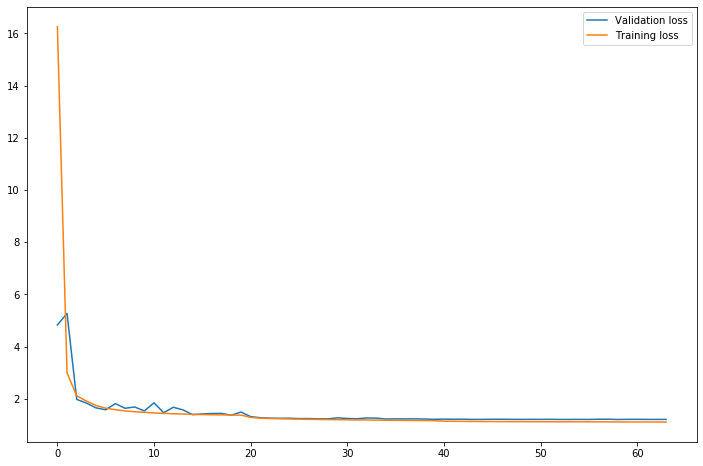

In [20]:
# loss history for simple cnn model
cnn_history = model.history.history
plt.figure(figsize=(12, 8))
plt.plot(cnn_history["val_loss"], label="Validation loss")
plt.plot(cnn_history["loss"], label="Training loss")
plt.legend();

In [21]:
cnn_history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

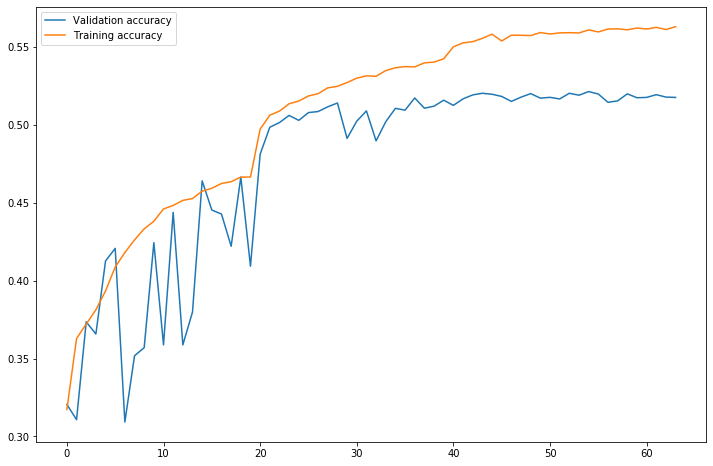

In [22]:
# accuracy history
plt.figure(figsize=(12, 8))
plt.plot(cnn_history["val_accuracy"], label="Validation accuracy")
plt.plot(cnn_history["accuracy"], label="Training accuracy")
plt.legend();

## Warning, do not run until the model is done!!!

In [23]:
# final metrics for the model computed on the test set
final_model_metrics = model.evaluate(x_test, y_test)

21352/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [24]:
print("The final loss on the test set is:", final_model_metrics[0])
print("The final accuracy on the test set is:", final_model_metrics[1])

The final loss on the test set is: 1.2174682178136427
The final accuracy on the test set is: 0.51929563


In [ ]:
print(final_model_metrics)

In [ ]:
model.evaluate(x_val, y_val)

In [ ]:
model.predict(x_val)

In [75]:
def load_images(image_paths, image_shape = (64, 64, 3)):
    # Load image
    data_generator = image.ImageDataGenerator(rescale=1. / 255)
    loaded_image = image.load_img(image_paths, target_size=image_shape)

    # Convert PIL image to numpy ndarray
    loaded_image = image.img_to_array(loaded_image)

    # Add another dimension (Add batch dimension)
    loaded_image = np.expand_dims(loaded_image, axis=0)

    return data_generator.standardize(loaded_image)

In [110]:
my_face = load_images('IMG_20191016_135708.jpg')

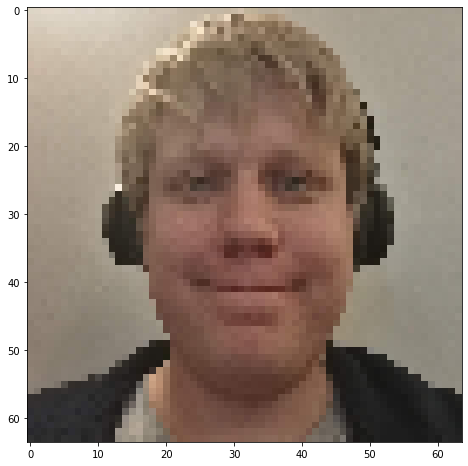

In [111]:
plt.figure(figsize=(12, 8))
plt.imshow(my_face[0])

In [ ]:
model.predict(my_face)